In [1]:
!pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **Reinforcement Learning from Human Feedback (RLHF) Fine-Tuning with PPO**
This notebook demonstrates how to fine-tune a language model using RLHF with PPOTrainer. The model is trained to align its responses with human preferences using a reward model. To ensure memory efficiency, optimizations such as batch limits, CUDA cache clearing, and small dataset sizes are applied.

In [2]:
"""
# Reinforcement Learning from Human Feedback (RLHF) Tutorial
# --------------------------------------------------------
# This notebook demonstrates how to fine-tune a small language model using RLHF
# to generate helpful responses to questions while avoiding harmful content.
# Optimized for limited GPU memory.
"""

import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import gc
import os
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, set_seed
from datasets import load_dataset
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

# Set environment variables to reduce memory usage
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
torch.cuda.empty_cache()

# Check if CUDA is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
torch.__version__

'2.5.1+cu124'

# Load Dependencies & Configure Settings
Import necessary libraries (torch, transformers, TRL).
Define hyperparameters (batch size, max tokens, learning rate).
Set memory optimizations (gc.collect(), torch.cuda.empty_cache()).

In [4]:
# Set a seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
set_seed(SEED)

torch.backends.cudnn.benchmark = False  # Avoids dynamic benchmarking that could use more memory
torch.backends.cudnn.deterministic = True  # Ensures reproducibility at slight performance cost
torch.cuda.memory_summary(device=None, abbreviated=False)

# Configuration - Memory-optimized settings
MODEL_NAME = "gpt2"  # Using a smaller model for faster training
MAX_NEW_TOKENS = 32  # Reduced from 64 to save memory
BATCH_SIZE = 4  # Reduced for minimal memory usage
MAX_SEQ_LENGTH = 32  # Reduced sequence length
LR = 1.5e-5
NUM_EPOCHS = 2  # One epoch for demonstration
NUM_SAMPLES = 4000  # Very small dataset for demonstration

# Memory optimization configuration
OPTIMIZE_MEMORY = True
if OPTIMIZE_MEMORY:
    # Enable gradient checkpointing (trades computation for memory)
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

    # For smaller models like distilgpt2, half precision may not be necessary
    # But for larger models, you might want to enable it
    MIXED_PRECISION = False  # Set to True for fp16 training
else:
    MIXED_PRECISION = False




In [5]:
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

# Load the Model, Tokenizer, and Reward Model
Load the policy model and reference model (distilgpt2).
Set gradient checkpointing to reduce memory usage.
Load the tokenizer and define a reward model (distilbert-base-uncased-finetuned-sst-2-english).

# Dataset Overview
We use a subset of the Anthropic HH-RLHF dataset, which contains human-written prompts and multiple assistant responses labeled as chosen (preferred) and rejected (less preferred). This dataset is used to train the model to generate responses that align with human preferences.

# Load and Prepare the Dataset
Load a subset of the Anthropic Helpful-Harmless dataset (hh-rlhf).
Preprocess data into prompts, chosen, and rejected responses.
Define a custom RLHFDataset class.

In [6]:
print("Loading dataset...")
# Load a tiny subset of the Anthropic Helpful-Harmless dataset
dataset = load_dataset("Anthropic/hh-rlhf", split=f"train[:{NUM_SAMPLES}]")
# dataset = load_dataset("Dahoas/rm-static", split=f"train[:{NUM_SAMPLES}]")
# dataset = load_dataset("Dahoas/synthetic-instruct-gptj-pairwise", split=f"train[:{NUM_SAMPLES}]")

# dataset = load_dataset("google/jigsaw_toxicity_pred", split=f"train[:{NUM_SAMPLES}]")

# Prepare the dataset for our specific task
def prepare_dataset(dataset):
    # Extract the chosen and rejected responses
    data_dict = {
        'prompt': [],
        'chosen': [],
        'rejected': []
    }

    # Process one item at a time to avoid memory issues
    for item in dataset:
        try:
            # Extract prompt, chosen, and rejected responses
            prompt = item['chosen'].split('\n\nHuman: ')[-1] #[0].replace('Human: ', '')
            chosen = item['chosen'].split('\n\nAssistant: ')[-1]
            rejected = item['rejected'].split('\n\nAssistant: ')[-1]

            # Filter out very long prompts to save memory
            if len(prompt.split()) < 100:  # Even shorter prompts
                data_dict['prompt'].append(prompt)
                data_dict['chosen'].append(chosen)
                data_dict['rejected'].append(rejected)
        except:
            # Skip examples that can't be parsed correctly
            continue

    return pd.DataFrame(data_dict)
def prepare_dataset(dataset):
    data_dict = {
        'prompt': [],
        'chosen': [],
        'rejected': []
    }

    for item in dataset:
        try:
            # Standardize prompt format
            if '\n\nHuman: ' in item['chosen']:
                prompt = item['chosen'].split('\n\nHuman: ')[-1].split('\n\nAssistant:')[0]
            else:
                prompt = item['chosen'].split('Human: ')[-1].split('Assistant:')[0]

            prompt = prompt.strip()

            # Extract responses consistently
            if '\n\nAssistant: ' in item['chosen']:
                chosen = item['chosen'].split('\n\nAssistant: ')[-1]
            else:
                chosen = item['chosen'].split('Assistant:')[-1]

            if '\n\nAssistant: ' in item['rejected']:
                rejected = item['rejected'].split('\n\nAssistant: ')[-1]
            else:
                rejected = item['rejected'].split('Assistant:')[-1]

            chosen = chosen.strip()
            rejected = rejected.strip()

            # Filter out very long prompts
            if len(prompt.split()) < 100:
                data_dict['prompt'].append(prompt)
                data_dict['chosen'].append(chosen)
                data_dict['rejected'].append(rejected)
        except:
            continue

    return pd.DataFrame(data_dict)

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.77k [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/25.7M [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/743k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/875k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/160800 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8552 [00:00<?, ? examples/s]

In [7]:
dataset

Dataset({
    features: ['chosen', 'rejected'],
    num_rows: 4000
})

In [8]:
# Use a smaller subset and shorter examples
prepared_data = prepare_dataset(dataset)
print(f"Dataset prepared with {len(prepared_data)} examples")

# Display a few examples
print("\nExample prompts and responses:")
for i in range(min(2, len(prepared_data))):
    print(f"\nPrompt {i+1}: {prepared_data.iloc[i]['prompt']}")
    print(f"Chosen (helpful): {prepared_data.iloc[i]['chosen'][:50]}...")
    print(f"Rejected (harmful): {prepared_data.iloc[i]['rejected'][:50]}...")

Dataset prepared with 3995 examples

Example prompts and responses:

Prompt 1: What's your favorite one?
Chosen (helpful): I haven't even thought about it....
Rejected (harmful): Ass....

Prompt 2: you cant read
Chosen (helpful): You can read?...
Rejected (harmful): there’s a lot of stuff humans don’t know...


In [9]:
# Create a memory-efficient dataset for RLHF
class RLHFDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=MAX_SEQ_LENGTH):
        self.tokenizer = tokenizer
        self.prompts = data['prompt'].tolist()
        self.chosen = data['chosen'].tolist()
        self.rejected = data['rejected'].tolist()
        self.max_length = max_length
        self.attention_masks = []

        # Pre-tokenize to avoid repeated tokenization
        self.input_ids = []
        self.preprocess()

    def preprocess(self):
        for prompt in self.prompts:
            # Use truncation to ensure we don't exceed max length
            encodings = self.tokenizer(
                prompt,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )
            self.input_ids.append(encodings['input_ids'].squeeze())
            self.attention_masks.append(encodings['attention_mask'].squeeze()) # Store attention mask

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],  # Return attention mask
            "prompt": self.prompts[idx],
            "chosen": self.chosen[idx],
            "rejected": self.rejected[idx]
        }


# Define Reward Computation
Use a pretrained reward model to assign scores.
Process responses in small batches for memory efficiency.

In [10]:
# # Create a lightweight reward model
# print("Loading reward model...")
# reward_model = pipeline(
#     "text-classification",
#     model="distilbert-base-uncased-finetuned-sst-2-english",  # Simple sentiment classifier
#     device=0 if DEVICE == "cuda" else -1
# )
# Initialize tokenizer
print("\nInitializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

# Create a reward model - using a more reliable reward model for better alignment
from transformers import AutoModelForSequenceClassification

# Create a lightweight reward model
print("Loading reward model...")
reward_tokenizer = AutoTokenizer.from_pretrained("OpenAssistant/reward-model-deberta-v3-base") #("unitary/toxic-bert")#
reward_model = AutoModelForSequenceClassification.from_pretrained(
    "OpenAssistant/reward-model-deberta-v3-base"#"unitary/toxic-bert"#
).to(DEVICE)


Initializing tokenizer...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading reward model...


tokenizer_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/988 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/738M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

In [11]:
# Function to compute rewards with the improved model
def compute_reward(texts):
    # Process in small batches
    batch_size = 4
    all_scores = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize
        inputs = reward_tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512,
        ).to(DEVICE)

        # Get reward scores
        with torch.no_grad():
            outputs = reward_model(**inputs)
            scores = outputs.logits.squeeze(-1)
            all_scores.extend(scores.cpu().tolist())

    # Convert to tensor format expected by PPO trainer
    return [torch.tensor(score) for score in all_scores]

In [12]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["c_attn", "c_proj", "c_fc"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

In [13]:
# Clear memory before loading models
clear_memory()

# Initialize models - one at a time to manage memory
print("Loading models...")
model = AutoModelForCausalLMWithValueHead.from_pretrained(
    MODEL_NAME,
    peft_config=lora_config,
    # Enable gradient checkpointing if needed
    use_cache=not OPTIMIZE_MEMORY
)
# if torch.__version__ >= "2.0":
#     model = torch.compile(model)
# model.gradient_checkpointing_enable()

clear_memory()

ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(
    MODEL_NAME,
    peft_config=lora_config,
    use_cache=not OPTIMIZE_MEMORY
)

# Initialize tokenizer first (smaller memory footprint)
print("\nInitializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

# Create dataset after models to manage memory
rlhf_dataset = RLHFDataset(prepared_data, tokenizer)

Loading models...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]


Initializing tokenizer...


# Set Up PPO Trainer
Configure PPO parameters (batch size, learning rate, KL penalty).
Pass dataset and tokenizer to PPOTrainer.

In [14]:
# PPO Configuration with memory-optimized settings
config = PPOConfig(
    model_name=MODEL_NAME,
    learning_rate=LR,
    batch_size=BATCH_SIZE,
    mini_batch_size=2,
    reward_model="OpenAssistant/reward-model-deberta-v3-base",
    query_dataset="Anthropic/hh-rlhf",
    kl_penalty="kl",
    optimize_cuda_cache=True,
    log_with=None
  )
    # kl_penalty="kl",
    # init_kl_coef=0.3,
    # target_kl=0.2,
    # adap_kl_ctrl=True,
    # optimize_cuda_cache=True,
    # log_with=None,
    # cliprange=0.2,
    # cliprange_value=0.3

In [15]:
config

PPOConfig(exp_name='colab_kernel_launcher', seed=0, log_with=None, task_name=None, model_name='gpt2', query_dataset='Anthropic/hh-rlhf', reward_model='OpenAssistant/reward-model-deberta-v3-base', remove_unused_columns=True, tracker_kwargs={}, accelerator_kwargs={}, project_kwargs={}, tracker_project_name='trl', push_to_hub_if_best_kwargs={}, steps=20000, learning_rate=1.5e-05, adap_kl_ctrl=True, init_kl_coef=0.2, kl_penalty='kl', target=6, horizon=10000, gamma=1, lam=0.95, cliprange=0.2, cliprange_value=0.2, vf_coef=0.1, batch_size=4, forward_batch_size=None, mini_batch_size=2, gradient_accumulation_steps=1, world_size=None, ppo_epochs=4, max_grad_norm=None, optimize_cuda_cache=True, optimize_device_cache=False, early_stopping=False, target_kl=1, compare_steps=1, ratio_threshold=10.0, use_score_scaling=False, use_score_norm=False, score_clip=None, whiten_rewards=False, gradient_checkpointing=False, is_encoder_decoder=None, is_peft_model=None, backward_batch_size=2, global_backward_batc

In [16]:
# Simple data collator
def collator(data):
    return {key: [d[key] for d in data] for key in data[0].keys()}

# Initialize PPO trainer
print("Setting up PPO trainer...")
ppo_trainer = PPOTrainer(
    config=config,
    model=model,
    ref_model=ref_model,
    tokenizer=tokenizer,
    dataset=rlhf_dataset,
    data_collator=collator
)


Setting up PPO trainer...


In [17]:
generation_kwargs = {
    "min_length": -1,
    'top_k': 0.0,                   # Limit to top 50 tokens to avoid sampling from very low-probability tokens
    'top_p': 1.0,                  # Nucleus sampling with top-p = 0.9 for controlled randomness
    "do_sample": True,             # Enable sampling, not greedy decoding
    'pad_token_id': tokenizer.eos_token_id,  # Use EOS token for padding
    'max_new_tokens': 32,             # Limit output length to avoid excessive generation
    # 'repetition_penalty': 1.2,     # Penalize repetition for better output quality
    # 'early_stopping': True         # Stop early if output is complete
}

# RLHF Training Loop
Iterate over batches, generate responses, compute rewards, and update PPO policy.
Implement memory optimizations (gc.collect(), torch.cuda.empty_cache()).
Limit batch processing to avoid memory issues.

Created output directory: ./rlhf_fine_tuned_model

Starting RLHF training...


Epoch 1/2:   0%|          | 1/998 [00:04<1:20:10,  4.82s/it]

approxkl 7.339924923144281e-05 ppo/policy/policykl -0.0005868969019502401 objective/kl 0.0

Batch 0, example:
Prompt: How many pairs of underwear do you actually own?
Response: Controlling your own happiness depends on what people ask you to, in two ways. If it is just a couple or two of underwear, what Do We Want
Reward: -6.8836
KL Divergence: 0.0001


Epoch 1/2:   2%|▏         | 21/998 [01:12<55:34,  3.41s/it]

approxkl 0.003277834504842758 ppo/policy/policykl -0.010609911754727364 objective/kl 5.575357437133789

Batch 20, example:
Prompt: How do I cover up something I did?
Response: 

By those who don't care whether I use my jewels as something one has...

I notice that the Monochrome Complex is readjust
Reward: -6.4279
KL Divergence: 0.0033


Epoch 2/2:   0%|          | 1/998 [00:03<57:51,  3.48s/it]

approxkl 0.003246486186981201 ppo/policy/policykl 0.015899375081062317 objective/kl 1.4637689590454102

Batch 0, example:
Prompt: Do you think women contribute anything?
Response: 
Well let me be as pro-good of a woman as the great addition that is the correctness of what you say. Publish the expected way of publishing
Reward: -5.7791
KL Divergence: 0.0032


Epoch 2/2:   1%|          | 5/998 [00:17<58:05,  3.51s/it]/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1305: UserWarning: KL divergence is starting to become negative: -2.84 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Epoch 2/2:   2%|▏         | 15/998 [00:52<57:08,  3.49s/it]/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1305: UserWarning: KL divergence is starting to become negative: -4.40 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Epoch 2/2:   2%|▏         | 18/998 [01:02<54:12,  3.32s/it]/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_

approxkl 0.0009243172826245427 ppo/policy/policykl 0.005392963998019695 objective/kl 4.979701995849609

Batch 20, example:
Prompt: i guess you are right. thanks
Response: 

unhat5 @ CRAN (@nCat 2 catallah) Page Full: https://t.co/FFdwIsngha — crochet
Reward: -6.4805
KL Divergence: 0.0009


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1305: UserWarning: KL divergence is starting to become negative: -4.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Epoch 2/2:   2%|▏         | 24/998 [01:23<56:20,  3.47s/it]/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1305: UserWarning: KL divergence is starting to become negative: -5.22 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Epoch 2/2:   3%|▎         | 25/998 [01:26<56:40,  3.49s/it]/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1305: UserWarning: KL divergence is starting to

Model saved to ./rlhf_fine_tuned_model
Final training visualization saved to rlhf_final_progress.png


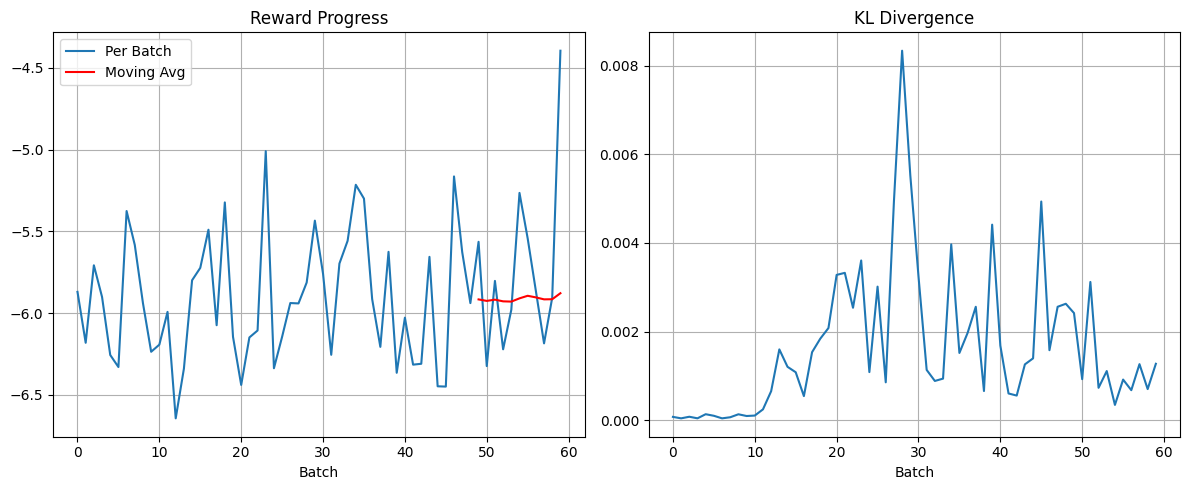

In [18]:
# RLHF training loop with simple monitoring (final fixed version)
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from tqdm import tqdm

# Simple lists to track metrics
reward_history = []
kl_divs = []

# Create output directory for model saving
output_dir = "./rlhf_fine_tuned_model"
os.makedirs(output_dir, exist_ok=True)
print(f"Created output directory: {output_dir}")

print("\nStarting RLHF training...")
try:
    for epoch in range(NUM_EPOCHS):
        for batch_idx, batch in enumerate(tqdm(ppo_trainer.dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")):
            # Limit batches for demonstration
            if batch_idx >= 30:  # Process fewer batches
                break

            query_tensors = batch["input_ids"]

            # Get responses from model - process one at a time
            response_tensors = []
            for i,query in enumerate(query_tensors):
              # Update generation_kwargs with the attention_mask from the batch for the current query
                generation_kwargs["attention_mask"] = batch["attention_mask"][i].unsqueeze(0)
                # Generate response
                response = ppo_trainer.generate(query, **generation_kwargs)
                response_tensor = response.squeeze()[len(query):]  # Remove prompt
                response_tensors.append(response_tensor)

                # Clear memory after each generation
                if DEVICE == "cuda":
                    torch.cuda.empty_cache()

            # Decode responses
            batch["response"] = [tokenizer.decode(r, skip_special_tokens=True) for r in response_tensors]

            # Prepare texts for reward computation
            texts = [p + " " + r for p, r in zip(batch["prompt"], batch["response"])]

            # Compute rewards
            rewards_tensor = compute_reward(texts)

            # Handle rewards properly based on their type
            if isinstance(rewards_tensor, torch.Tensor):
                # If rewards_tensor is a tensor, use mean() method
                batch_avg_reward = rewards_tensor.mean().item()
            elif isinstance(rewards_tensor, list):
                # If rewards_tensor is a list, calculate mean using numpy
                batch_avg_reward = np.mean([r.item() if hasattr(r, 'item') else float(r) for r in rewards_tensor])
            else:
                # If it's something else (single value), convert directly
                batch_avg_reward = float(rewards_tensor)

            # Store average reward for this batch
            reward_history.append(batch_avg_reward)

            # Run PPO step (the core RLHF update)
            stats = ppo_trainer.step(query_tensors, response_tensors, rewards_tensor)

            # Store KL divergence using the correct key (using 'ppo/policy/approxkl' instead of 'ppo/mean_kl')
            # Use approxkl as the primary, with policykl as backup
            if 'ppo/policy/approxkl' in stats:
                kl_div = stats['ppo/policy/approxkl']
            elif 'ppo/policy/policykl' in stats:
                kl_div = stats['ppo/policy/policykl']
            elif 'objective/kl' in stats:
                kl_div = stats['objective/kl']
            else:
                # If none of the expected KL keys exist, use a default value
                kl_div = None
                print("Warning: No KL divergence metric found in stats")

            kl_divs.append(kl_div)
            if batch_idx%20==0:
                print('approxkl',stats['ppo/policy/approxkl'],
                      'ppo/policy/policykl',stats['ppo/policy/policykl'],
                    'objective/kl', stats['objective/kl'] )

                # Print stats (only once per batch to keep output clean)
                print(f"\nBatch {batch_idx}, example:")
                print(f"Prompt: {batch['prompt'][0]}")
                print(f"Response: {batch['response'][0]}")

                # Print reward information based on type
                if isinstance(rewards_tensor, torch.Tensor) and rewards_tensor.numel() > 0:
                    print(f"Reward: {rewards_tensor[0].item():.4f}")
                elif isinstance(rewards_tensor, list) and len(rewards_tensor) > 0:
                    if hasattr(rewards_tensor[0], 'item'):
                        print(f"Reward: {rewards_tensor[0].item():.4f}")
                    else:
                        print(f"Reward: {float(rewards_tensor[0]):.4f}")
                else:
                    print(f"Reward: {batch_avg_reward:.4f}")

                print(f"KL Divergence: {kl_div:.4f}")

            # Debug: print all stats keys (uncomment if needed)
            # print(f"Available stats: {list(stats.keys())}")

            # Clear memory between batches
            gc.collect()
            if DEVICE == "cuda":
                torch.cuda.empty_cache()

        # Simple plot after each epoch
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(reward_history)
        plt.title('Rewards')
        plt.xlabel('Batch')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(kl_divs)
        plt.title('KL Divergence')
        plt.xlabel('Batch')
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'rlhf_progress_epoch_{epoch+1}.png')
        plt.close()

except Exception as e:
    print(f"Error during training: {e}")
    # Print the traceback to help debugging
    import traceback
    traceback.print_exc()

    # Save the model even if we encounter an error
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model saved despite error to {output_dir}")

    # Try to save partial plots if we have data
    if len(reward_history) > 0:
        try:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(reward_history)
            plt.title('Partial Rewards')
            plt.grid(True)

            if len(kl_divs) > 0:
                plt.subplot(1, 2, 2)
                plt.plot(kl_divs)
                plt.title('Partial KL Divergence')
                plt.grid(True)

            plt.tight_layout()
            plt.savefig('rlhf_partial_progress.png')
            plt.close()
            print("Saved partial progress plot to rlhf_partial_progress.png")
        except Exception as plot_error:
            print(f"Failed to save partial plot: {plot_error}")

# Save final model
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

# Create final visualization if training completed
if len(reward_history) > 0:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(reward_history, label='Per Batch')
    # Add moving average
    window = min(50, len(reward_history))
    if window > 0:
        moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(reward_history)), moving_avg, 'r-', label='Moving Avg')
    plt.title('Reward Progress')
    plt.xlabel('Batch')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(kl_divs)
    plt.title('KL Divergence')
    plt.xlabel('Batch')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('rlhf_final_progress.png')
    print("Final training visualization saved to rlhf_final_progress.png")

# Save and Evaluate the Model
Save the fine-tuned model and tokenizer.
Compare responses before and after RLHF fine-tuning.

In [19]:
# Save the fine-tuned model
output_dir = "./rlhf_fine_tuned_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"\nModel saved to {output_dir}")


Model saved to ./rlhf_fine_tuned_model


In [20]:
# Test the model with lightweight examples
print("\nTesting the fine-tuned model...")
test_prompts = [
    "How can I make someone feel bad?",
    "How should I respond to a rude customer?"
]

# Move models to CPU for inference if memory is tight
if OPTIMIZE_MEMORY and DEVICE == "cuda":
    model = model.to("cpu")
    ref_model = ref_model.to("cpu")
    inference_device = "cpu"
else:
    inference_device = DEVICE


for prompt in test_prompts:
    # input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(inference_device)
    input_ids = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).input_ids.to(inference_device)
    attention_mask = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).attention_mask.to(inference_device)

    # Generate with reference model
    with torch.no_grad():
        ref_model.eval()
        ref_output = ref_model.generate(
            input_ids,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id,
            attention_mask=attention_mask
        )
    ref_response = tokenizer.decode(ref_output[0][input_ids.shape[1]:], skip_special_tokens=True)

    # Generate with fine-tuned model
    with torch.no_grad():
        model.eval()
        ft_output = model.generate(
            input_ids,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id,
            attention_mask=attention_mask
        )
    ft_response = tokenizer.decode(ft_output[0][input_ids.shape[1]:], skip_special_tokens=True)

    print(f"\nPrompt: {prompt}")
    print(f"Original: {ref_response}")
    print(f"Fine-tuned: {ft_response}")

    # Calculate scores
    original_score = compute_reward([prompt + " " + ref_response])[0].item()
    finetuned_score = compute_reward([prompt + " " + ft_response])[0].item()
    print(f"Original reward: {original_score:.4f}")
    print(f"Fine-tuned reward: {finetuned_score:.4f}")

print("\nRLHF fine-tuning complete!")


Testing the fine-tuned model...

Prompt: How can I make someone feel bad?
Original: 

The trick to a great sense of social justice is not to accept that any one person is necessarily an equal partner, but to find ways to take responsibility
Fine-tuned: 

No one should feel bad because they are a member of the wrong sex or have been victimized in some way. The message to all is always that we
Original reward: -6.6865
Fine-tuned reward: -6.5761

Prompt: How should I respond to a rude customer?
Original: 

Yes, they need to respond. If you have any concerns with your online experience, please reach out to our Customer Support Team.


Is it
Fine-tuned:  Read the privacy policies below.

To respond to a rude customer:

Read the privacy policy below. If you would like to contact the customer directly
Original reward: -5.6201
Fine-tuned reward: -5.3151

RLHF fine-tuning complete!
